# Data Cleaning and Exploratory Data Analysis

## Feature effects (from base linear model)

Polynomial Regression R²: 0.053
Mean Squared Error: 469.023


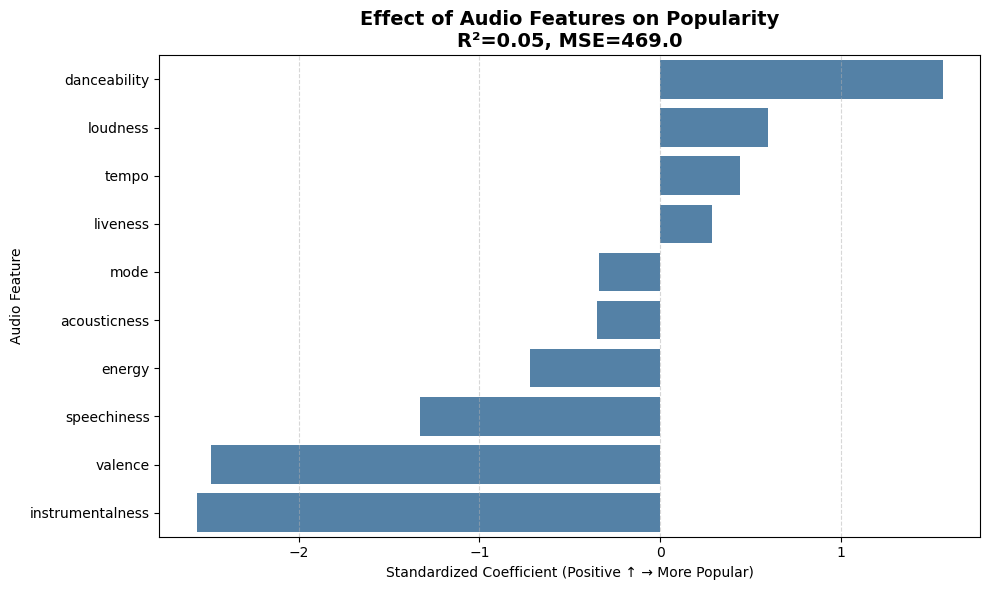

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

spotify = pd.read_csv("../data/spotify_tracks.csv")

features = [
    "danceability", "energy", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "loudness", "mode"
]
df = spotify.dropna(subset=["popularity"] + features)
X = df[features]
y = df["popularity"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Polynomial Regression R²: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")

base_model = LinearRegression()
base_model.fit(X_scaled, y)

coeff_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": base_model.coef_
}).sort_values("Coefficient", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coeff_df, x="Coefficient", y="Feature", color="steelblue")
plt.title(f"Effect of Audio Features on Popularity\nR²={r2:.2f}, MSE={mse:.1f}", fontsize=14, weight='bold')
plt.xlabel("Standardized Coefficient (Positive ↑ → More Popular)")
plt.ylabel("Audio Feature")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

1️. Model Quality: The polynomial regression model achieves an $R^2$ of 0.05, indicating that musical audio features alone explain about 5% of the variability in track popularity. This suggests that while some characteristics (like danceability or loudness) influence song success, the majority of variance stems from non-acoustic factors such as artist recognition, social trends, and algorithmic promotion.

2️. Positive Influences: Danceability and loudness have the strongest positive coefficients, meaning that tracks that are easier to move to and sonically intense tend to be more popular. Tempo and energy also show moderate positive effects which means upbeat tracks usually perform better.

3️. Negative Influences: Instrumentalness and valence (positivity) have negative coefficients which means too few vocals or overly “happy” tracks may perform worse commercially. Acousticness is slightly negative, suggesting that modern listeners favor more produced, electronic sounds.

## Feature vs Popularity trendlines

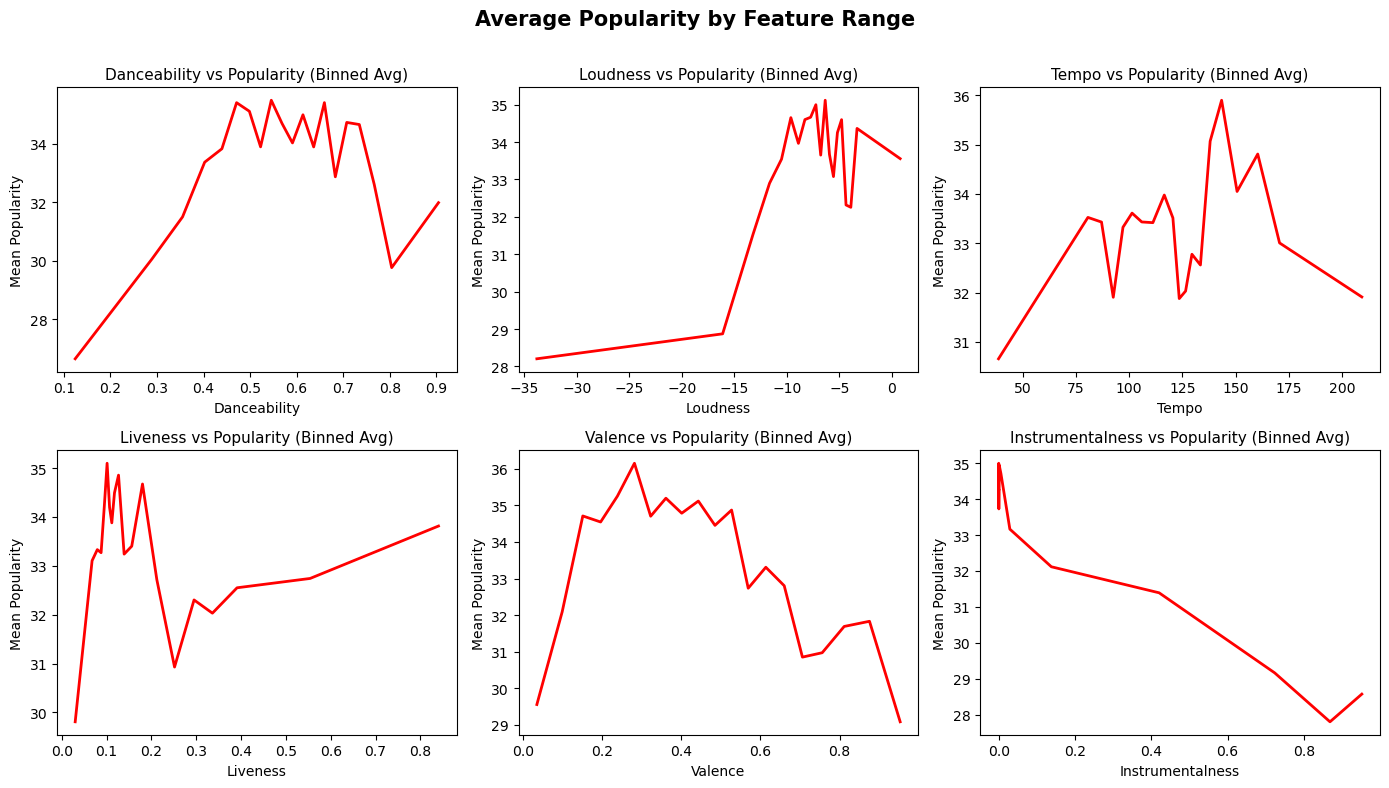

In [4]:
top_features = coeff_df["Feature"].head(4).tolist() + coeff_df["Feature"].tail(2).tolist()
fig, axes = plt.subplots(2, 3, figsize=(14,8))
for i, feature in enumerate(top_features):
    ax = axes[i//3, i%3]
    df["binned"] = pd.qcut(df[feature], 20, duplicates="drop")
    bin_means = df.groupby("binned", observed=False)["popularity"].mean()
    bin_centers = [interval.mid for interval in bin_means.index.categories]
    ax.plot(bin_centers, bin_means, color="red", linewidth=2)
    ax.set_title(f"{feature.capitalize()} vs Popularity (Binned Avg)", fontsize=11)
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Mean Popularity")

plt.suptitle("Average Popularity by Feature Range", fontsize=15, weight="bold")
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

1️. Danceability: Popularity rises steeply as danceability increases up to around 0.5–0.7, then slightly dips.

Meaning: The most successful songs tend to be moderately to highly danceable which means songs that are easy to move to (e.g., rhythmic pop, R&B, EDM) dominate the charts, but extremely repetitive or overproduced dance tracks might lose appeal.

2️. Loudness: Popularity stays low for quiet songs but increases sharply once loudness exceeds about –15 dB, plateauing near –5 dB.

Meaning: Louder, more compressed mixes (common in modern pop and hip-hop) correlate with higher popularity reflecting the “loudness war” trend in commercial production.

3️. Tempo: There’s a peak in popularity between roughly 110–150 BPM, then a slight drop.

Meaning: Mid-to-fast tempo songs, energetic but not frantic, perform best. This aligns with typical radio and club tempos (e.g., pop, dance, and rap genres).

4️. Liveness: Popularity fluctuates but shows a mild increase at moderate levels of liveness.

Meaning: Songs with some live elements or ambience may feel authentic and appealing, but fully live recordings or heavily acoustic performances are less frequent in popular playlists.

5️. Valence (Positivity): Popularity peaks around 0.3–0.5, then falls for very happy songs.

Meaning: People favor songs that are balanced in mood neither too sad nor overly cheerful. This explains why moody pop and bittersweet lyrics dominate modern charts (e.g., Billie Eilish, The Weeknd).

6️. Instrumentalness: Popularity decreases steadily as instrumentalness increases.

Meaning: Vocals are key, tracks with lyrics (low instrumentalness) are consistently more popular. Purely instrumental songs are niche.

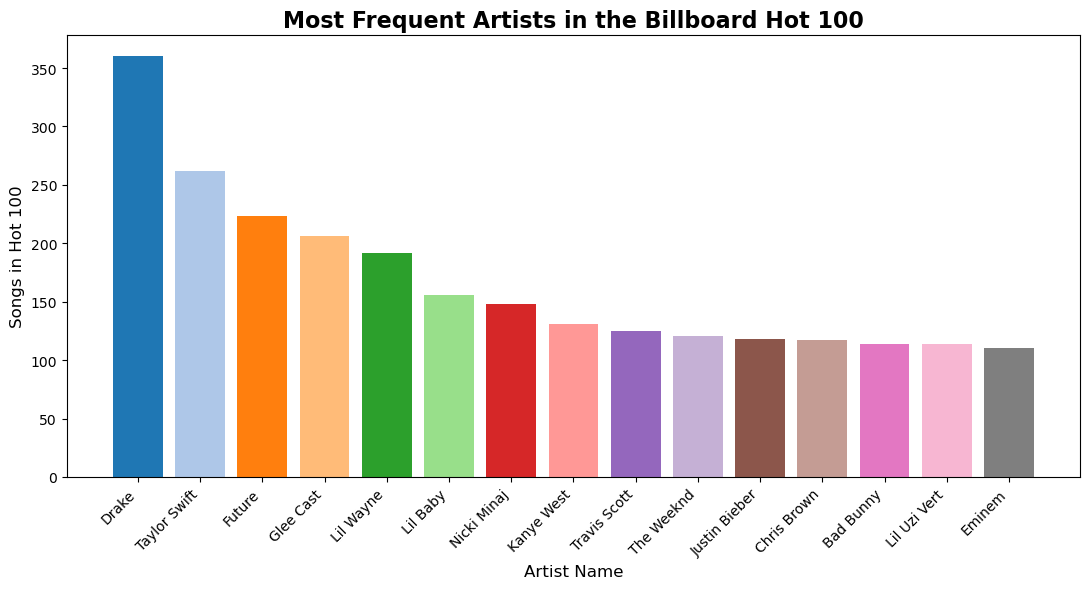

In [2]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

hot100 = pd.read_csv("../data/Hot 100.csv")

artist_col = "performer" 
song_col = "song" if "song" in hot100.columns else "title"
hot100 = hot100.dropna(subset=[artist_col, song_col])

unique_songs = hot100[[artist_col, song_col]].drop_duplicates()

def clean_artists(text):
    text = str(text)
    text = re.sub(r"[\[\]']", "", text)
    text = re.sub(r"(?i)\b(feat\.?|featuring|ft\.?)\b", ",", text)
    text = text.replace("&", ",").replace(" x ", ",").replace(" X ", ",")
    parts = [p.strip() for p in text.split(",") if p.strip()]
    return parts

expanded = []
for _, row in unique_songs.iterrows():
    artists = clean_artists(row[artist_col])
    for a in artists:
        expanded.append(a)

artist_counts = Counter(expanded)
artist_df = (
    pd.DataFrame(artist_counts.items(), columns=["Artist", "Count"])
    .sort_values("Count", ascending=False)
    .head(15)
)

plt.figure(figsize=(11,6))
colors = plt.cm.tab20(range(len(artist_df)))

plt.bar(artist_df["Artist"], artist_df["Count"], color=colors)
plt.title("Most Frequent Artists in the Billboard Hot 100",
          fontsize=16, weight='bold')
plt.xlabel("Artist Name", fontsize=12)
plt.ylabel("Songs in Hot 100", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()
